In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

### Business Questions

1. What is the biggest factor (if any) in the success of a Kickstarter project
2. What category of project would most likely succeed (Art, Photography, Tech etc.)
3. Are there any discernible differences between successful and failed projects?

### Data Understanding

So I tackled with the above business questions during the course of my data exploration process. Since roughly 35% of Kickstarter projects succeed, and, given a sample size of more than 300,000 projects, there should be a sufficient amount of data to warrant a robust investigation for determining the reasons behind certain failures and/or successes of these projects.

### Gather the Data

In [2]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")

In [3]:
df.head()

ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency    deadline     goal  \
0          Poetry    Publishing      GBP  2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26  45000.0   
3           Music         Music      USD  2012-04-16   5000.0   
4    Film & Video  Film & Video      USD  2015-08-29  19500.0   

              launched  pledged     state  backers country  usd pledged  \
0  2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1  2017-09-02 04:43:57   2421.0    failed       15      US        100.0   
2  2013-01-12 00:20:50    220.0    failed        3      US        220.0   
3  2012-03-17 03:24:11      1.0    failed        1      US          1.0   
4  2015-07-04 08:35:03   1283.0  canceled       14      US       1283.0   

   usd_pledged_real  usd_goal_real  
0               0.0        1533.95  
1            2421.0       30000.00  
2             220.0       45000.00  
3               1.0        5000.00  
4            1283.0       19500.00

In [4]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [5]:
df['deadline'] = pd.to_datetime(df['deadline'])

In [6]:
print(df.shape)

(378661, 15)


In [7]:
df.columns = [s.replace(' ','') for s in df.columns]

### Cleaning the Data

In [8]:
# Look at the null values
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usdpledged          3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [9]:
df.category.value_counts()

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [10]:
df.main_category.value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

In [11]:
print(len(df.category.unique()))
print(len(df.main_category.unique())) 
#main_category will help us keep dimensionality low after one hot encoding

159
15


In [12]:
df.shape[0]==len(df.ID.unique()) #ID column is unique, but doesnt give us much info

True

Dropping / Removing these features:

- goal:  as it is in local currency, and it would be easier to work with usd_goal_real 
- currency:  as we will just use the information that is already converted to USD
- usd pledged:  it has missing values, it is Kickstarter information given about pledge amount in USD but this is already included in usd_pledged_real 
- pledged:  is funding raised in local currency
- category:  main_category retains a lot of information, and will still increase our number of features quite significantly when one hot encoded. If we were to try to one hot encode category the dimensionality of our data would be very high.
- ID:  all of the ID fields are unique, and it will not give us any information about project success

In [13]:
#convert to common datetime format
df.launched = pd.to_datetime(df.launched)

In [14]:
#investigate data about countries
df.country.value_counts()

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

In [15]:
#N,0" engineering to 'NO'
df.country = df.country.replace(to_replace='N,0"', value='NO')

Here I assume that in the country variable the value N,0" is an error, and am rewriting that as NO.

I will engineer a "success" variable from the information that is already in the dataset. I am defining success by a project raising at least as much as their goal had stipulated. This is also how Kickstarter defines success.

In [16]:
#engineer a 'success' variable
df['success'] = (df.usd_goal_real <= df.usd_pledged_real)*1

In [17]:
df.success.describe()

count    378661.000000
mean          0.361912
std           0.480554
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: success, dtype: float64

So I decided to engineer a "duration" feature to see if the timeline of a project influences the chances at success. The dataset contains information about the date and time a project was launched, and what the fundraising deadline was. From this it is straightforward to calculate how many hours the fundraising was supposed to last.

In [18]:
#engineer duration variable
df['duration'] = (df.deadline - df.launched).astype('timedelta64[h]')

Furthermore, I decided to one-hot encode the categorical variables: main_category and country. This means that each state in each feature will be represented as a binary state. For example, if a project originated in the U.S., that will be denoted as a value of 1 in the dataset and all other countries will have a value of 0 for that project. The goal is to make it easier for any models we deal with by quantifying non-numerical values.

In [19]:
#one hot encode categorical variables, dropping unneeded variables
df_encoded = pd.get_dummies(df.drop(labels=['name', 'launched', 'deadline', 'state',
                                            'category', 'currency', 'usdpledged', 'pledged',
                                            'ID', 'goal'], axis=1), 
                            columns=['main_category', 'country'])

The average amount contributed to a project can give us some insight about whether we want to encourage many small contributions or a few larger ones.

In [20]:
#add a variable that shows average pledge for each project
df_encoded['average_backing'] = (df_encoded['usd_pledged_real']/(df_encoded['backers']+1))

### Data Analysis

So I now want to start off understanding the data that underlies Kickstarter projects. This includes things like places of origin, predominant categories, durations, goals etc.

C:\Users\mahjo\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


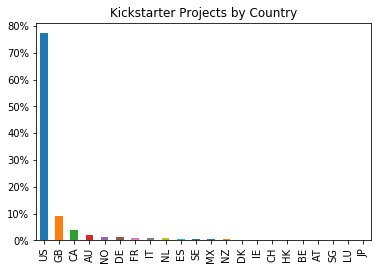

In [21]:
# Look to the module.py file to track the import methods
from module import percent_plot

percent_plot((df.country.value_counts()/df.shape[0]*100), "Kickstarter Projects by Country")

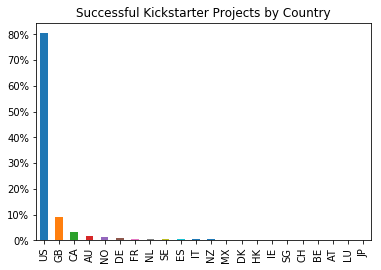

In [22]:
#successful projects by country`
percent_plot((df[df.usd_pledged_real>=df.usd_goal_real].country.value_counts()/
              df[df.usd_pledged_real>=df.usd_goal_real].shape[0]*100), 
             "Successful Kickstarter Projects by Country")

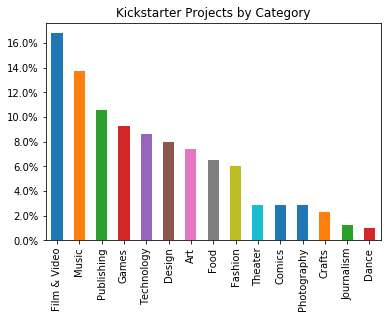

In [23]:
percent_plot((df.main_category.value_counts()/df.shape[0]*100), 
             "Kickstarter Projects by Category")

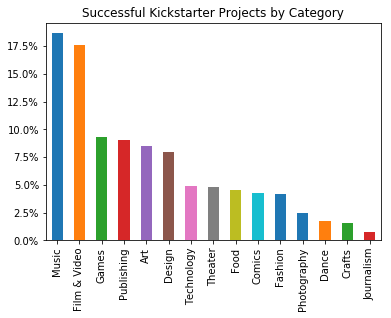

In [24]:
#categories of successful projects
percent_plot((df[df.usd_pledged_real>=df.usd_goal_real].main_category.value_counts()/
              df[df.usd_pledged_real>=df.usd_goal_real].shape[0]*100), 
             "Successful Kickstarter Projects by Category")

Text(0,0.5,'# of projects')

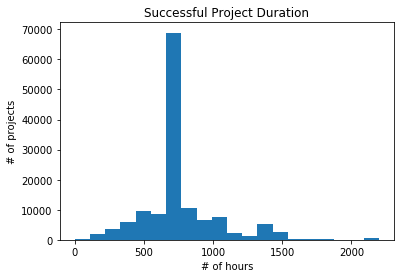

In [25]:
plt.hist(df_encoded[df_encoded.success==1].duration, bins=20)
plt.title('Successful Project Duration')
plt.xlabel('# of hours')
plt.ylabel('# of projects')

In [26]:
df_encoded[df_encoded.success==1].duration.describe()

count    137042.000000
mean        758.118548
std         282.562915
min           0.000000
25%         696.000000
50%         707.000000
75%         809.000000
max        2200.000000
Name: duration, dtype: float64

In [27]:
df_encoded[df_encoded.success==0].duration.describe()

count    241619.000000
mean        844.839739
std        1968.206205
min           0.000000
25%         699.000000
50%         714.000000
75%         949.000000
max      401735.000000
Name: duration, dtype: float64

In [28]:
df_encoded[df_encoded.success==1].usd_goal_real.describe()

count    1.370420e+05
mean     9.477405e+03
std      2.773888e+04
min      1.000000e-02
25%      1.323050e+03
50%      3.807055e+03
75%      1.000000e+04
max      2.015609e+06
Name: usd_goal_real, dtype: float64

In [29]:
df_encoded[df_encoded.success==0].usd_goal_real.describe()

count    2.416190e+05
mean     6.585991e+04
std      1.442797e+06
min      1.000000e-02
25%      2.690480e+03
50%      7.559720e+03
75%      2.200000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

In [30]:
df_encoded[df_encoded.success==1].average_backing.describe()

count    1.370420e+05
mean     1.667539e+02
std      7.484850e+03
min      3.950000e-01
25%      4.036037e+01
50%      6.254378e+01
75%      1.026918e+02
max      2.762572e+06
Name: average_backing, dtype: float64

In [31]:
df_encoded[df_encoded.success==0].average_backing.describe()

count    241619.000000
mean         43.500706
std         125.853411
min           0.000000
25%           0.535833
50%          19.575000
75%          49.021940
max       17425.000000
Name: average_backing, dtype: float64

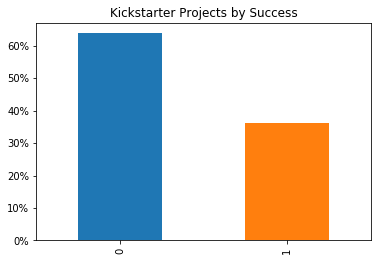

In [32]:
percent_plot((df_encoded.success.value_counts()/df.shape[0]*100),
             "Kickstarter Projects by Success")

### Descriptive Statistics

What can we learn from looking at some descriptive statistics? What is correlated with success? We have to keep in mind that correlation does not imply causality, but this could give us a good idea anyway.

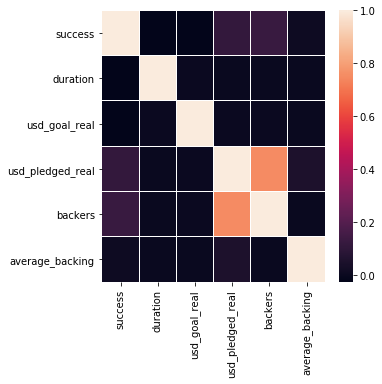

In [33]:
def corr_plot(features, fig_size):
    '''
    INPUT: features- which columns of df_encoded to calculate correlation
            fig_size- size of the correlation heatmap for ease of reading
    OUTPUT: Seaborn Heatmap of Correlations
    '''
    corr = df_encoded[features].corr()
    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            ax = ax, linewidths=0.01)

#correlation between the time, and goal and pldeged money
corr_plot(['success','duration', 'usd_goal_real', 
                        'usd_pledged_real', 'backers', 'average_backing'], (5,5))

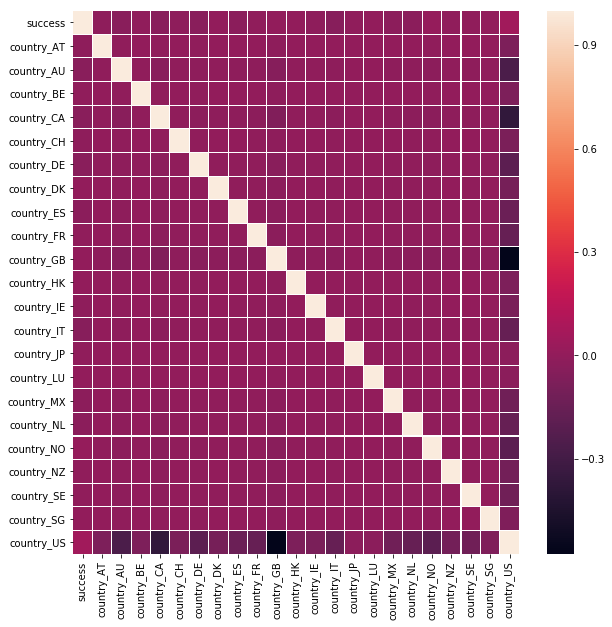

In [34]:
#correlation between success and country of origin for project
corr_plot(['success', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO',
       'country_NZ', 'country_SE', 'country_SG', 'country_US'], (10,10))

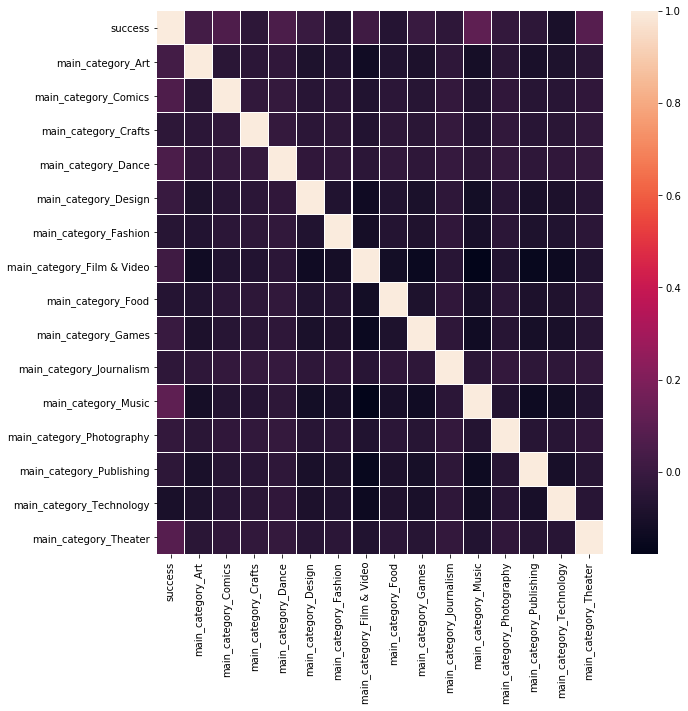

In [35]:
#correlation between sphere of project and success
corr_plot(['success','main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater'], (10,10))

In [36]:
#number of dollars pledged per hour
(df_encoded.usd_pledged_real/(df_encoded.duration+1)).describe()

count    378661.000000
mean         11.976360
std         116.407377
min           0.000000
25%           0.040531
50%           0.842644
75%           5.575035
max       27010.605936
dtype: float64

### ML Classification Model

Let's see if we can accurately predict which projects will be successful and which ones won't. We'll use a random forest classifier as this ensemble learner is usually quite powerful, and is not distance based (so we dont have to further scale the features like duration or usd_pledged_real or usd_goal_real)

In [37]:
# Look to the module.py file to track the import methods
from module import rfc_model
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(['success'], axis='columns').values,
                                                    df_encoded.success, 
                                                    test_size=0.2)

In [38]:
rfc_model(42, X_train, X_test, y_train, y_test)

0.9953785007856548
[0.218 0.376 0.244 0.018 0.001 0.001 0.    0.001 0.002 0.001 0.001 0.001
 0.002 0.    0.005 0.    0.001 0.003 0.002 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.
 0.001 0.    0.    0.    0.001 0.118]


This model does quite well, However we did include the usd_pledged_real and the backers features in this which might be skewing the results - we should remember that usd_pledged_real and backers were very highly correlated with success.

Let's remove this variable and see how the model does.

In [39]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').values, 
    df_encoded.success, test_size=0.2, random_state=0)
rfc_model(42, X_train_2, X_test_2, y_train_2, y_test_2)

0.7959277989779885
[0.219 0.184 0.002 0.005 0.002 0.002 0.003 0.003 0.003 0.002 0.004 0.001
 0.009 0.002 0.003 0.004 0.004 0.    0.002 0.    0.002 0.    0.001 0.001
 0.001 0.001 0.003 0.    0.    0.001 0.    0.    0.001 0.001 0.002 0.001
 0.001 0.    0.004 0.526]


In [40]:
# Look to the module.py file to track the import methods
from module import print_important_features

print_important_features([0,2,13], df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns'))

usd_goal_real
main_category_Art
main_category_Photography


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

#grid search to optimize random forest classifier
parameters={'n_estimators':[5,10,15,20],
            'max_depth':[None,2,5,10,15],
            'min_samples_split':[2, 4, 8]}
clf = RandomForestClassifier(random_state=42)
scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train_2, y_train_2)
best_clf = grid_fit.best_estimator_

In [42]:
predictions = best_clf.predict(X_test_2)

In [43]:
print(accuracy_score(y_test_2, predictions))

0.8165264811904982


In [44]:
best_clf.feature_importances_.round(3)

array([0.205, 0.058, 0.002, 0.007, 0.002, 0.003, 0.002, 0.006, 0.002,
       0.002, 0.004, 0.001, 0.017, 0.001, 0.002, 0.008, 0.008, 0.   ,
       0.001, 0.   , 0.001, 0.   , 0.001, 0.   , 0.   , 0.   , 0.001,
       0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.002, 0.   ,
       0.   , 0.   , 0.003, 0.656])

In [45]:
#which features were most important in model
print_important_features([0,2,4,8,13,17], df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns'))

usd_goal_real
main_category_Art
main_category_Crafts
main_category_Film & Video
main_category_Photography
country_AT


### Conclusion

Based on the feature importance of the Random Forest Ensemble Learner, the most important features are usd_goal_real, main_category_Art, main_category_Crafts, main_category_Film & Video, main_category_Photography, and country_AT. This shows us that what we set as the monetary goal and how long we allow people to pledge for really does matter a lot. 

So I would NOT say there's any one factor in contributing to a project success on Kickstarter. Many aspects might contribute to it which cannot be explained through the data. For example, the business idea, planning, incentives to pledge, or project design cannot be easily quantified. 

Perhaps if we had sentiment data from the comments on each project we could then combine that information into a much larger and better classification model for predicting our success. 